In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)



Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import time
import gc
import sys
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import time
import seaborn as sns
import pandas.core.indexes as i
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import  Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
import keras
from keras import layers


In [ ]:
copied_path='/content/drive/MyDrive/9z_ML_Bootcamp/Wafer_Defects/1LSWMD.pkl'
data=pd.read_pickle(copied_path)


In [ ]:
data_backup=data
df=data
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 811457 entries, 68241 to 52137
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 83.3+ MB


In [ ]:
df = df.drop(['waferIndex'], axis = 1)

In [ ]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
509241,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 2,...",515.0,lot31777,[],[],"(25, 27)"
355625,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6052.0,lot21253,[],[],"(86, 89)"
182608,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3036.0,lot11631,[[Training]],[[Edge-Ring]],"(63, 62)"
21667,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot2529,[],[],"(26, 30)"
393670,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1226.0,lot23606,[],[],"(40, 40)"


In [ ]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [ ]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

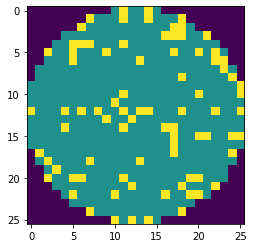

Faulty case : ['none'] 


In [ ]:
# plot 1st data
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [ ]:
x = x.reshape((-1, 26, 26, 1))

In [ ]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [ ]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [ ]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

In [ ]:
# parameter
epoch=15
batch_size=1024

In [ ]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [ ]:
# start train
ae.fit(new_x, new_x,
       batch_size=64,
       epochs=30)

Epoch 1/30
225/225 [==============================] - 1s 3ms/step - loss: 0.0969
Epoch 2/30
225/225 [==============================] - 1s 3ms/step - loss: 0.0187
Epoch 3/30
225/225 [==============================] - 1s 3ms/step - loss: 0.0084
Epoch 4/30
225/225 [==============================] - 1s 3ms/step - loss: 0.0050
Epoch 5/30
225/225 [==============================] - 1s 3ms/step - loss: 0.0035
Epoch 6/30
225/225 [==============================] - 1s 3ms/step - loss: 0.0026
Epoch 7/30
225/225 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 8/30
225/225 [==============================] - 1s 3ms/step - loss: 0.0017
Epoch 9/30
225/225 [==============================] - 1s 3ms/step - loss: 0.0014
Epoch 10/30
225/225 [==============================] - 1s 3ms/step - loss: 0.0012
Epoch 11/30
225/225 [==============================] - 1s 3ms/step - loss: 0.0011
Epoch 12/30
225/225 [==============================] - 1s 3ms/step - loss: 9.4504e-04
Epoch 13/30
225/225 [

In [ ]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [ ]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [ ]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

In [ ]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

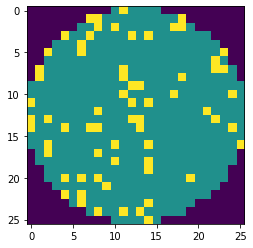

In [ ]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

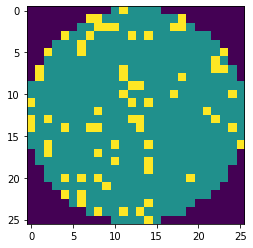

In [ ]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

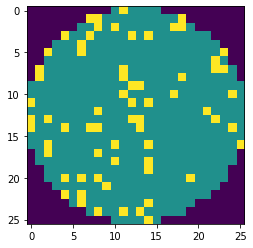

In [ ]:
# check reconstructed original faulty wafer data
gen_x = np.argmax(ae.predict(new_x), axis=3)
plt.imshow(gen_x[3])

In [ ]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [ ]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

In [ ]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))


After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [ ]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=1100, replace=False)]

In [ ]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [ ]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (18607, 26, 26, 3), new_y shape : (29607, 1)


In [ ]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 12389


In [ ]:
# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [ ]:
# split data train, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.33,
                                                    random_state=2019)

ValueError: ignored

In [ ]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (2,2), padding='same', activation='relu', input_shape = (int(resize_img),int(resize_img),RGB)))

model.add(Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size = (3,3), padding='same', activation='relu'))
model.add(BatchNormalization(momentum=0.1))
model.add(MaxPooling2D(3,3))
model.add(Dropout(0.25))

model.add(Flatten())




model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))


model.add(Dense(9, activation='softmax'))

In [ ]:
# Make keras model to sklearn classifier.
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=1024, verbose=2) 
# 3-Fold Crossvalidation
kfold = KFold(n_splits=3, shuffle=True, random_state=2019) 
results = cross_val_score(model, x_train, y_train, cv=kfold)
# Check 3-fold model's mean accuracy
print('Simple CNN Cross validation score : {:.4f}'.format(np.mean(results)))

In [ ]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train,
         validation_data=(x_test, y_test),
         epochs=epoch,
         batch_size=batch_size,
         )

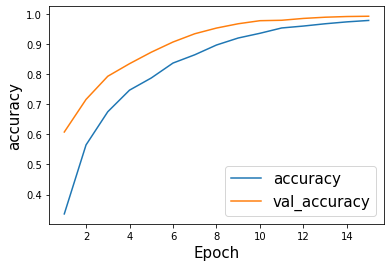

In [ ]:
c=history
accuracy  = c.history['accuracy']
val_accuracy = c.history['val_accuracy']

val_loss=c.history['val_loss']
loss=c.history['loss']

train_epoch=range(1,16)
plt.plot(train_epoch,accuracy , label='accuracy')
plt.plot(train_epoch,val_accuracy , label='val_accuracy')

plt.xlabel('Epoch', fontsize=15)
plt.ylabel('accuracy',fontsize=15)
plt.legend(fontsize=15)

text=('best accuracy' ,max(val_accuracy),)

#plt.text(1,0.9940,text,fontsize =12)

In [ ]:
df=pd.DataFrame()
df['epoch']=train_epoch
df['val_acc']=val_accuracy
df['test_acc']=accuracy
df['val_loss']=val_loss
df['test_loss']=loss
df.to_csv('Alexnet1.csv') 

#from google.colab import files
#files.download("Alexnet1.csv")

In [ ]:
y_test_pred=np.round(model.predict(x_test),0)
y_test_pred.shape

y_predict_classes = [np.argmax(y, axis=None, out=None) for y in y_test_pred]
y_test_class= [np.argmax(y, axis=None, out=None) for y in y_test]
len(y_test_class)

6504

In [ ]:
from sklearn import metrics

classification_metrics=metrics.classification_report(y_predict_classes,y_test_class, target_names=n_classes)
print(classification_metrics)

              precision    recall  f1-score   support

      Center       1.00      0.99      0.99       721
       Donut       1.00      1.00      1.00       671
    Edge-Loc       1.00      0.97      0.99       796
   Edge-Ring       1.00      1.00      1.00       676
         Loc       0.98      0.98      0.98       790
   Near-full       1.00      1.00      1.00       699
      Random       1.00      1.00      1.00       701
     Scratch       1.00      0.99      1.00       680
        none       0.95      1.00      0.97       770

    accuracy                           0.99      6504
   macro avg       0.99      0.99      0.99      6504
weighted avg       0.99      0.99      0.99      6504



In [ ]:
y_predict_classes=pd.DataFrame(y_predict_classes)
y_test_class=pd.DataFrame(y_test_class)

for i, j in enumerate(n_classes):

  y_predict_classes[y_predict_classes==i]=n_classes[i]
  y_test_class[y_test_class==i]=n_classes[i]
y_predict_classes=y_predict_classes.to_numpy()
y_test_class=y_test_class.to_numpy()
y_predict_classes

array([['none'],
       ['Near-full'],
       ['Donut'],
       ...,
       ['Scratch'],
       ['Donut'],
       ['Edge-Loc']], dtype=object)

In [ ]:
n_classes

array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch', 'none'], dtype=object)

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')    

Normalized confusion matrix


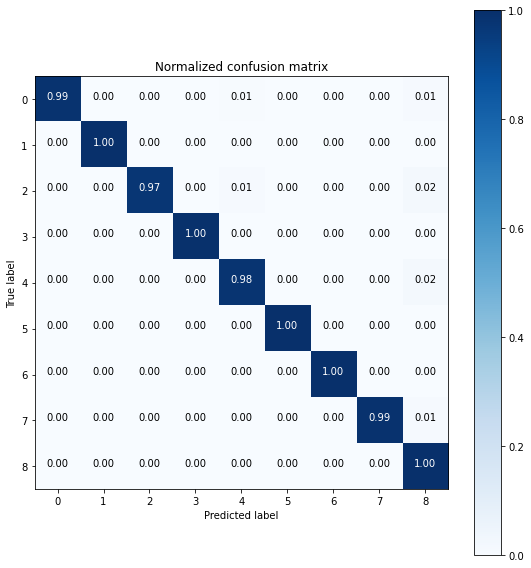

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


cnf_matrix = confusion_matrix(y_predict_classes, y_test_class)
np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 


# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix,   title='Normalized confusion matrix', normalize=True )


plt.show()

In [ ]:
n_classes

array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch', 'none'], dtype=object)

In [ ]:
y_predict_classes

array([['none'],
       ['Near-full'],
       ['Donut'],
       ...,
       ['Scratch'],
       ['Donut'],
       ['Edge-Loc']], dtype=object)

In [ ]:
y_predict_classes


array([['none'],
       ['Near-full'],
       ['Donut'],
       ...,
       ['Scratch'],
       ['Donut'],
       ['Edge-Loc']], dtype=object)

In [ ]:
n_classes[1]

In [ ]:
y_predict_classes